
# Brewery Analysis: Machine Learning



---



*  Data is preprocessed and cleaned by removing unneeded columns, merging zip code/cities datasets, and limiting dataset to the top 1,000 most populated cities.
*  To obtain the best possible predictive results, preliminary features should be explored, engineered, and carefully selected. Possible preliminary features for this model could be average income per zipcode, income per capita, and clothing stores per brewery count.
*  The importance of correlation between breweries and outdoor clothing stores will drive which features will be engineered and selected, ultimately answering the hypthesis.
*  Data was split into training and testing sets using train_test_split and a random state of 24. This will assist in evaluating the performance of the model in relation to the dataset.
*  A linear regression model was chosen to best illustrate correlation between brewery location and outdoor clothing store location. Is there a strong relationship between the two? The benefits of using a linear regression is readability and abiility to answer basic questions. Limitations of a linear regression model will be sensitivity to outliers. With more time we would like to also set up a cluster model.





In [1]:
# Import dependencies

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

from database_connection import ENGINE

# Data Selection

In [2]:
# Connect to city_summary database
city_summary = '''
    SELECT *
    FROM city_summary
'''

city_summary_df = pd.read_sql_query(
    city_summary,
    con=ENGINE
)

city_summary_df.sample(10)

,city,state,mean_income,min_income,max_income,median_income,first_quartile_income,third_quartile_income,num_breweries,breweries_num_one_star_reviews,breweries_num_five_star_reviews,breweries_mean_rating,num_outdoor_stores,outdoor_num_one_star_reviews,outdoor_num_five_star_reviews,outdoor_mean_rating,population,lat,lon,ts_updated
301,Columbus,IN,215376,44523,500863,196715,120479,270910,20,0,3,4.025000,4,0,2,4.625000,67360,39.220000,-85.870000,2022-08-24 21:00:34.821677+00:00
592,Gig Harbor,WA,192013,12513,1004382,80458,45805,131844,15,0,2,4.233333,6,0,2,4.250000,53110,47.340000,-122.643333,2022-08-24 21:00:34.821677+00:00
716,Pasadena,TX,98606,6377,298102,94946,62964,114787,8,0,0,4.312500,6,0,1,3.333333,128167,29.670000,-95.160000,2022-08-24 21:00:34.821677+00:00
554,Smyrna,GA,301770,44362,950920,222218,114047,431970,12,0,0,4.208333,2,0,0,4.250000,69060,33.855000,-84.525000,2022-08-24 21:00:34.821677+00:00
378,Greenville,NC,228233,100313,601172,173988,152739,244276,10,0,1,4.100000,6,0,3,4.583333,80740,35.625000,-77.375000,2022-08-24 21:00:34.821677+00:00
292,Lakeland,FL,132822,12257,676157,113858,60763,156618,10,0,1,4.000000,2,0,0,3.750000,219280,28.051111,-81.948889,2022-08-24 21:00:34.821677+00:00
988,Acworth,GA,302309,86787,847078,196166,167784,284085,4,0,1,4.625000,7,0,0,3.357143,96420,34.075000,-84.650000,2022-08-24 21:00:34.821677+00:00
532,Saint Peters,MO,457651,126447,1040039,397994,332992,453578,5,0,1,4.200000,5,0,1,3.600000,71500,38.770000,-90.600000,2022-08-24 21:00:34.821677+00:00
687,Fairfield,CA,356293,53728,851553,295931,160034,446326,17,0,2,4.294118,6,0,0,3.416667,109260,38.255000,-122.060000,2022-08-24 21:00:34.821677+00:00
686,Duluth,MN,64842,5129,311144,35086,22128,70050,17,0,3,4.294118,18,0,4,3.944444,94930,46.813000,-92.124000,2022-08-24 21:00:34.821677+00:00


# Data Processing

In [4]:
# Set X and y for linear regression model
X = city_summary_df.num_breweries.values.reshape(-1,1)
y = city_summary_df.num_outdoor_stores.values.reshape(-1,1)
print(X.shape)
print(y.shape)

(1000, 1)
(1000, 1)


# Data Transformation

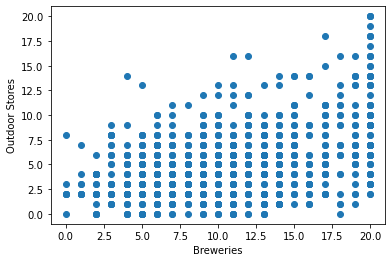

In [5]:
plt.scatter(city_summary_df.num_breweries, city_summary_df.num_outdoor_stores)
plt.xlabel('Breweries')
plt.ylabel('Outdoor Stores')
plt.show()

In [6]:
# Create an instance of the model(LinearRegression)
model = LinearRegression()

In [7]:
# Train the model with the dataset 
model.fit(X,y)

LinearRegression()

In [8]:
# r squared value of the model
model.score(X,y)

0.18187765031067693

In [9]:
y_pred = model.predict(X)

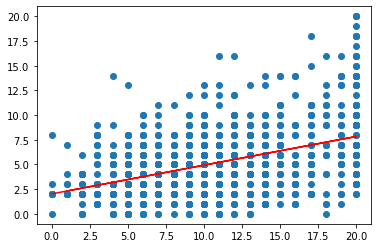

In [10]:
# Visualize trendline
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.show()

In [11]:
# Find model slope and intercept
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_) 

Weight coefficients:  [[0.29016989]]
y-axis intercept:  [2.02925685]


In [12]:
# Model formula
print(f"y = {model.coef_[0][0]}x + {model.intercept_[0]}")

y = 0.29016988606941885x + 2.0292568525372836


In [13]:
# Find Accuracy of predictions
predictions = model.predict(X)
print(f"True output: {y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {predictions[0]-y[0]}")

True output: [2]
Predicted output: [2.02925685]
Prediction Error: [0.02925685]


# Multiple Linear Regression

In [33]:
# Remove categorical inputs that are not needed for this model
mlr_city_summary = city_summary_df.drop(columns = ["city","state","ts_updated","breweries_num_one_star_reviews","breweries_num_five_star_reviews","outdoor_num_one_star_reviews","outdoor_num_five_star_reviews","lat","lon",'breweries_mean_rating','outdoor_mean_rating'])
mlr_city_summary.sample(5)

,mean_income,min_income,max_income,median_income,first_quartile_income,third_quartile_income,num_breweries,num_outdoor_stores,population
327,339378,10973,2893386,103727,36562,237597,19,13,77960
390,236011,70099,426022,221161,174594,294202,10,3,61220
631,158853,6474,1069559,125138,56380,185278,20,10,182690
894,190075,4749,2563042,105781,70957,181234,12,4,671910
80,302278,26885,1502201,146240,78216,352416,9,2,98030


In [34]:
# Get column names to be used when creating scaled df
mlr_city_summary_columns = mlr_city_summary.columns
mlr_city_summary_columns

Index(['mean_income', 'min_income', 'max_income', 'median_income',
       'first_quartile_income', 'third_quartile_income', 'num_breweries',
       'num_outdoor_stores', 'population'],
      dtype='object')

In [35]:
# Get column names without num_outdoor_stores to be used in ColumnTransformer function
summary_columns_no_outdoor = mlr_city_summary.columns.drop("num_outdoor_stores")
summary_columns_no_outdoor

Index(['mean_income', 'min_income', 'max_income', 'median_income',
       'first_quartile_income', 'third_quartile_income', 'num_breweries',
       'population'],
      dtype='object')

In [36]:
# Column names for use in making city_summary_scaled_df 
# Since ColumnTransformer function flipped the population and num_outdoor_stores columns, this is reflected in the column names
columns = ['mean_income', 'min_income', 'max_income', 'median_income',
       'first_quartile_income', 'third_quartile_income', 'num_breweries',
       'population', 'num_outdoor_stores']

In [37]:
# Scale data using StandardScaler and ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# features is the dataframe being passed into the ColumnTransformer function
features = mlr_city_summary

# ColumnTransformer applys the StandardScaler Function to all columns in the summary_columns_no_outdoor list, 
# and passes over any others(num_outdoor_stores)
ct = ColumnTransformer([
        ('data_scaler', StandardScaler(), summary_columns_no_outdoor)
    ], remainder='passthrough')

city_summary_scaled = ct.fit_transform(features)

In [38]:
# Create new dataframe with the scaled data, leaving the num_outdoor_stores not scaled since it is out output
city_summary_scaled_df = pd.DataFrame(city_summary_scaled, columns = columns)
city_summary_scaled_df.sample(5)

,mean_income,min_income,max_income,median_income,first_quartile_income,third_quartile_income,num_breweries,population,num_outdoor_stores
231,-1.122758,-0.651778,-0.765554,-1.203471,-0.886513,-1.023532,-0.304265,-0.424586,2.0
781,-0.252602,0.356691,-0.432083,-0.268709,0.229165,-0.070632,-0.108596,-0.411911,7.0
426,-1.318324,-0.798139,-0.775603,-1.497411,-1.158572,-1.248958,0.282742,-0.444529,10.0
286,-0.693075,-0.330998,-0.618379,-0.555630,-0.360766,-0.572350,-1.086941,-0.195306,5.0
854,2.387919,2.320815,0.310102,2.195358,2.578242,3.465631,-0.891272,-0.348038,4.0


In [39]:
# Set X and y for model
X = city_summary_scaled_df.drop(columns = "num_outdoor_stores")
y = city_summary_scaled_df["num_outdoor_stores"]

In [40]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =27)

In [41]:
# Create an object of LinearRegression class
lr = LinearRegression()

# fitting the training data
lr.fit(X_train,y_train)

LinearRegression()

In [42]:
# Get predictions
y_pred = lr.predict(X_test)
y_pred

array([ 3.68180877,  7.89757975,  4.06983197,  4.3700393 ,  8.09216457,
        6.15419287,  5.46029903,  6.04457817,  4.28276954,  8.33887731,
        5.66402971,  7.30622823,  4.97439441,  7.73558635,  7.81911144,
        4.75083547,  7.69745106,  3.5667385 ,  5.25645355,  3.20955572,
        5.07205508,  4.72220442,  5.96294302,  8.85156597,  2.59292003,
        2.62371391,  9.07670094,  5.86827172,  4.47755223,  5.16823862,
        5.00004809,  4.8979788 ,  2.7946244 ,  3.55688992,  3.74190599,
        8.05297067,  3.52331433,  4.07875961,  2.73577027,  3.38190176,
        3.43269864,  6.44951986,  4.72643607,  4.86661583,  4.99402463,
        4.28317438,  5.46889109,  3.38170331,  4.92804104,  3.87990611,
        6.10222177,  6.85824907,  3.40983256,  4.29262317,  4.12816466,
        5.10303821,  7.79611565,  7.47183868,  3.47277617,  8.93451146,
        5.39734044,  4.78910244,  7.036277  ,  7.50888274,  3.50682694,
        4.86730389,  6.24257568,  9.15608188,  5.53929125,  6.40

In [43]:
# Display the predicted vs actual values for number of outdoor stores
error_df = pd.DataFrame({"Predicted": y_pred, "Actual": y_test, "Error": y_pred - y_test})[["Predicted", "Actual", "Error"]]
error_df

,Predicted,Actual,Error
754,3.681809,8.0,-4.318191
768,7.897580,14.0,-6.102420
23,4.069832,3.0,1.069832
47,4.370039,7.0,-2.629961
453,8.092165,4.0,4.092165
...,...,...,...
330,4.950160,2.0,2.950160
969,6.808631,8.0,-1.191369
156,5.232132,6.0,-0.767868
395,6.487459,2.0,4.487459


In [44]:
# importing r2_score module
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score=r2_score(y_test,y_pred)
print(f'r2 score is {score}')
print(f'mean_sqrd_error is {mean_squared_error(y_test,y_pred)}')
print(f'root_mean_squared error is {np.sqrt(mean_squared_error(y_test,y_pred))}')

r2 score is 0.10035962825263
mean_sqrd_error is 10.486568029236045
root_mean_squared error is 3.2382970878589945


In [45]:
# Find impact of different variables
lr.coef_

array([ 0.53079052, -0.10232197, -0.15365912, -0.11519817,  0.13558864,
       -0.53404309,  1.54042546,  0.42540372])

In [46]:
# Find the intercept
lr.intercept_

5.1989884965227295